# Playground to implement W&B as well as start hyperparameter-tuning

# WanDB

In [127]:
#%pip install wandb

In [1]:
import subprocess
import wandb
from wandb.keras import WandbCallback
import tensorflow as tf
import os

In [3]:
subprocess.call(['wandb', 'login', '4e8d3dcb1584ad129b3b49ccc34f65b20116ae54'])

0

In [4]:
wandb.init(project='precursor_charge_prediction')

wandb: Currently logged in as: nkopp (team-bioinf). Use `wandb login --relogin` to force relogin


## Setup

In [ ]:
#%pip install seaborn

In [5]:
import re
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.utils import class_weight
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import wandb
from wandb.keras import WandbCallback
import keras

In [6]:
train_datapath = ["data/"+file for file in os.listdir('data') if file.endswith(".parquet")][0]
batch_size = 32

# Dataset batches + split

In [7]:
import re
# the dictionary
aa_syntax_dictionary = dict()
for index, i in enumerate(list('XACDEFGHIKLMNPQRSTVWY')): # added X for 0 value
    aa_syntax_dictionary[i] = index * 100
    if i != 'X': # ignore 0 value for X
        for count in range(0, 100):
            aa_syntax_dictionary[i + "[UNIMOD:" + str(count) + "]"] = index * 100 + count

def seq_translator(sequence, dictionary=aa_syntax_dictionary, print_result=False):
    """
    Translates a sequence into a vector of integers
    :param sequence: string
    :param dictionary: dictionary
    :return: list
    """
    pattern = r'[A-Z]\[[^\]]*\]|.' # regex pattern to match amino acids and modifications

    result = [match for match in re.findall(pattern, sequence)]

    if print_result:
        print(result)
    # Fill the list with "X" characters until it reaches a length of 40
    result += ['X'] * (50 - len(result))

    return [dictionary[aa] for aa in result]


def one_hot_precursor(int_value, charges=[2,3,4]):
    """
    One-hot encodes the precursor charge
    :param df: dataframe
    :param max_charge_included: int
    :return: dataframe
    """
    one_hot = [1 if x == int_value else 0 for x in charges]

    return one_hot

In [8]:
print(seq_translator('AAC[UNIMOD:4]LLVAW', print_result=True))
print(one_hot_precursor(2))

['A', 'A', 'C[UNIMOD:4]', 'L', 'L', 'V', 'A', 'W']
[100, 100, 204, 1000, 1000, 1800, 100, 1900, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0]


In [9]:
file_list = ["data/"+file for file in os.listdir('data') if file.endswith('.parquet')]
print(file_list[0])

data/Thermo_SRM_Pool_meta_data.parquet


### import parquet files, drop all columns we dont need for training, one-hot encode precursor charge, translate sequence

In [10]:
batches_parquet = dict()
counter = 0
for file in file_list:
    df = pd.read_parquet(file, engine='fastparquet')
    # drop all columns we dont need for training
    for column in df.columns:
        if column not in ["modified_sequence","precursor_intensity", "precursor_charge"]:
            df.drop(column, axis=1, inplace=True)
    charge_ranges = [2, 3, 4] # TODO SET RANGES
    df = df[df["precursor_charge"].isin(charge_ranges)] # remove 7+ charge states // only take charge states 2,3,4
    df["modified_sequence_vector"] = df["modified_sequence"].apply(seq_translator)
    df["precursor_charge_vector"] = df["precursor_charge"].apply(one_hot_precursor, args=(charge_ranges,))
    df = df.dropna(subset=['precursor_intensity']) # drop rows with no precursor intensity
    batches_parquet[file] = df
    counter += 1
    if counter > 1:
        break # TODO REMOVE BREAK FOR FIRST FILE IN LIST

In [11]:
num_classes = len(charge_ranges)
class_names = charge_ranges

In [12]:
batches_parquet[file_list[0]].head()

,modified_sequence,precursor_charge,precursor_intensity,modified_sequence_vector,precursor_charge_vector
0,LPGSLETYVEQEQGENANDR,2,29525630.0,"[1000, 1300, 600, 1600, 1000, 400, 1700, 2000,...","[1, 0, 0]"
1,HGSLQEYLQNDTGSK,2,13188580.0,"[700, 600, 1600, 1000, 1400, 400, 2000, 1000, ...","[1, 0, 0]"
2,VEEEEEINSELTAR,2,20663460.0,"[1800, 400, 400, 400, 400, 400, 800, 1200, 160...","[1, 0, 0]"
3,LPGSLETYVEQEQGENANDR,2,19884630.0,"[1000, 1300, 600, 1600, 1000, 400, 1700, 2000,...","[1, 0, 0]"
4,NSSTAEINETTTSSTDFLAR,2,12804420.0,"[1200, 1600, 1600, 1700, 100, 400, 800, 1200, ...","[1, 0, 0]"


In [13]:
batches_parquet[file_list[0]]["precursor_charge"].value_counts()

2    4331294
3    1523398
4     115577
Name: precursor_charge, dtype: int64

### import preprocessed df's

In [14]:
# Make validation data
sample_df = batches_parquet[file_list[0]][["precursor_charge", "precursor_intensity", "modified_sequence_vector"]].copy()

In [ ]:
sample_df

In [15]:
# Split the data into train, validation, and test sets
sample_df["precursor_intensity"] = sample_df["precursor_intensity"].astype(int) # TODO or times 10 -> 0.1 = 1 .astype(int)
main_ds = np.array(sample_df[["precursor_intensity", "modified_sequence_vector"]]) # to list
main_ds_labels = np.array(sample_df['precursor_charge'])
max_len = max(sample_df.loc[:, 'modified_sequence_vector'].apply(len))  # Find the maximum length


# Create an instance of StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Perform the split
train_indicies, val_indicies = next(sss.split(main_ds, main_ds_labels))
train_ds, train_ds_labels = main_ds[train_indicies], main_ds_labels[train_indicies]
val_ds, val_ds_labels = main_ds[val_indicies], main_ds_labels[val_indicies]


charges = [2,3,4] # TODO SELECT CLASSES
num_classes = len(charges)

train_ds_labels, val_ds_labels = np.array([one_hot_precursor(i, charges = charges) for i in train_ds_labels]), np.array([one_hot_precursor(i, charges = charges) for i in val_ds_labels])

### Model

In [561]:
train_ds_b[1][0]

<tf.Tensor: shape=(1,), dtype=int32, numpy=array([600])>

In [562]:
train_ds.shape

(4776215, 2)

In [16]:
train_ds_a, train_ds_b, val_ds_a, val_ds_b = train_ds[:, 0], train_ds[:, 1:], val_ds[:, 0], val_ds[:, 1:]

In [17]:
train_ds_a = train_ds_a.reshape(train_ds_a.shape[0], 1)
val_ds_a = val_ds_a.reshape(val_ds_a.shape[0], 1)

In [565]:
train_ds_a.shape

(4776215, 1)

In [18]:
train_ds_a = tf.convert_to_tensor(train_ds_a, dtype=tf.int32)
val_ds_a = tf.convert_to_tensor(val_ds_a, dtype=tf.int32)

In [545]:
# train_ds_b = [np.array(x[0]).reshape(-1,1) for x in train_ds_b] # todo for rows

In [19]:
train_ds_b = [np.reshape(np.array(x[0]), (1, 50, 1)) for x in train_ds_b]
val_ds_b = [np.reshape(np.array(x[0]), (1, 50, 1)) for x in val_ds_b]

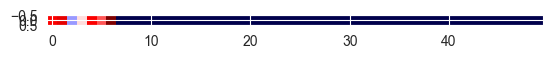

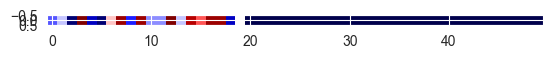

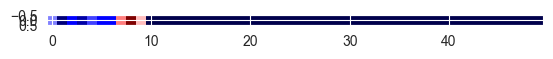

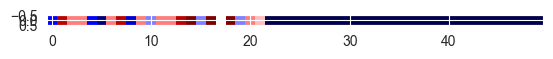

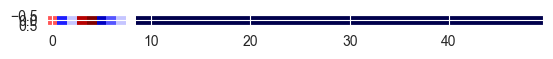

In [20]:
from matplotlib import pyplot as plt
for i in range(5):
    plt.imshow(train_ds_b[i], interpolation='nearest', cmap='seismic') # TODO CUSTOM COLORS FOR AA
    plt.show()

In [21]:
train_ds_b = tf.convert_to_tensor(train_ds_b)
val_ds_b = tf.convert_to_tensor(val_ds_b)

In [620]:
train_ds_b.shape

TensorShape([4776215, 1, 50, 1])

In [621]:
train_ds_b.shape[1:]

TensorShape([1, 50, 1])

In [619]:
train_ds_a.shape

(4776215,)

In [703]:
val_ds.shape

(1194054, 2)

In [690]:
#train_ds_labels = tf.convert_to_tensor(train_ds_labels)
#val_ds_labels = tf.convert_to_tensor(val_ds_labels)

In [701]:
train_ds_labels.shape

TensorShape([4776215, 3])

In [702]:
val_ds_labels.shape

TensorShape([1194054, 3])

In [22]:
from keras import Sequential, Model
from keras.layers import Embedding, Flatten, Dense, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Input, concatenate, Rescaling
# define two sets of inputs
inputA = Input(shape=(1,)) # TODO only 1 column for intensities
inputB = Input(shape=train_ds_b.shape[1:])
# the first branch operates on the first input
x = Model(inputs=inputA, outputs=inputA)
# the second branch operates on the second input
y = Rescaling(scale=1./2000)(inputB) # for dictionary of 2000 words (X = 0, aa 1-20 in 100 steps)
#y = Embedding(input_dim=2000, output_dim=3, input_length=50)(inputB)
y = Conv2D(filters=64, kernel_size=(1,3), strides=1, activation="relu", padding='same')(y)
y = MaxPooling2D(pool_size=(1,2), padding='same')(y)
y = Conv2D(filters=128, kernel_size=(1,3), strides=1, activation="relu", padding='same')(y)
y = MaxPooling2D(pool_size=(1,2), padding='same')(y)
y = Flatten()(y)
y = Dense(2000, activation="relu")(y)
y = Model(inputs=inputB, outputs=y)
# combine the output of the two branches
combined = concatenate([x.output, y.output])
# apply a FC layer and then a regression p0rediction on the
# combined outputs
z = Dense((inputA.shape[1]+inputB.shape[1]), activation="relu")(combined) # 1 + 50 = 51
#z = Flatten()(combined)
z = Dense(num_classes, activation="softmax")(combined)
# our model will accept the inputs of the two branches and
# then output a single value
model = Model(inputs=[x.input, y.input], outputs=z)

In [23]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1, 50, 1)]   0           []                               
                                                                                                  
 rescaling (Rescaling)          (None, 1, 50, 1)     0           ['input_2[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 1, 50, 64)    256         ['rescaling[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 1, 25, 64)    0           ['conv2d[0][0]']                 
                                                                                            

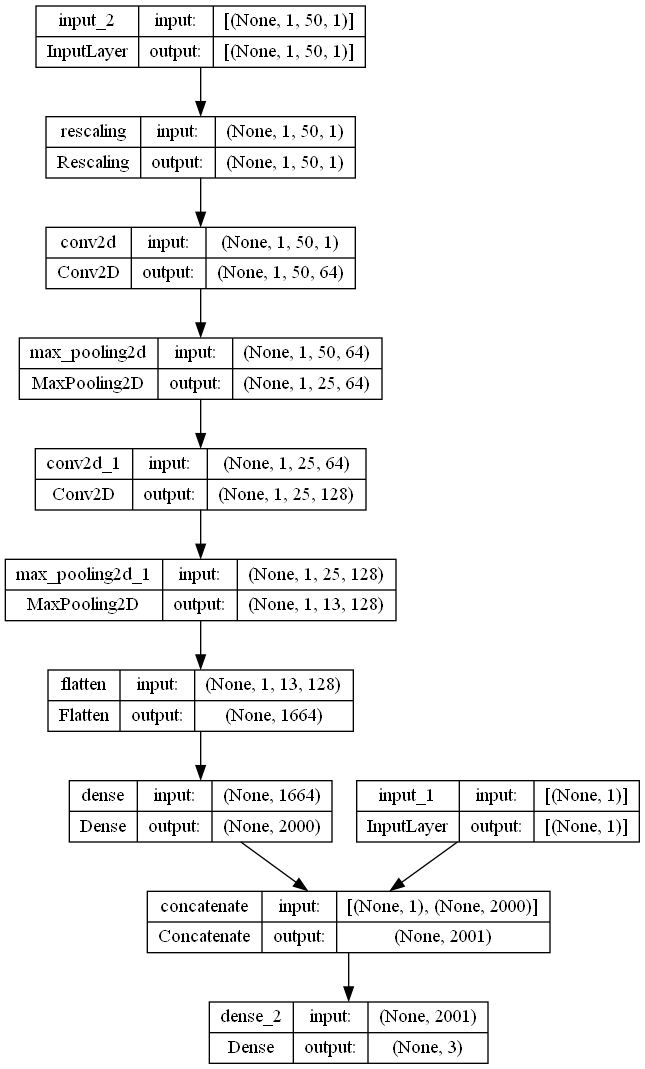

In [24]:
# plot model
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [25]:
# Compile the model
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])

In [26]:
checkpoint_callback = ModelCheckpoint('precursor_charge_prediction_model_v1/cce_wo7_allSequences.h5', monitor='val_accuracy', save_best_only=True, mode='max')

# Define early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [683]:
#steps_per_epoch = train_ds_b.shape[0] // 256

In [29]:
# Train the model
# X_train, X_test, y_train, y_test
history = model.fit([train_ds_a, train_ds_b], train_ds_labels, epochs=10, batch_size=4096, validation_data=([val_ds_a, val_ds_b], val_ds_labels), callbacks=[WandbCallback()])

In [748]:
# Access the loss, validation loss, and accuracy from the history object
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot the loss, validation loss, and accuracy curves
epochs = range(1, len(loss) + 1)

# Create subplots
fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot loss and validation loss
ax1.plot(epochs, loss, 'b', label='Training Loss')
ax1.plot(epochs, val_loss, 'r', label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot accuracy and validation accuracy
ax2.plot(epochs, accuracy, 'b', label='Training Accuracy')
ax2.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

In [30]:
model.save('precursor_charge_prediction_conv2d_model/big_conv2d_model.h5')

# Inference

In [13]:
inf_model = tf.keras.models.load_model('precursor_charge_prediction_conv2d_model/model_1_test.h5')

In [14]:
# Make validation data
sample_df_inf = batches_parquet[file_list[1]][["precursor_charge", "precursor_intensity", "modified_sequence_vector"]].copy()

In [42]:
# Split the data into train, validation, and test sets
sample_df_inf["precursor_intensity"] = sample_df_inf["precursor_intensity"].astype(int) # TODO or times 10 -> 0.1 = 1 .astype(int)
main_ds_inf = np.array(sample_df_inf[["precursor_intensity", "modified_sequence_vector"]]) # to list
main_ds_labels_inf = np.array(sample_df_inf['precursor_charge'])
max_len_inf = max(sample_df_inf.loc[:, 'modified_sequence_vector'].apply(len))  # Find the maximum length

charges = [2,3,4] # TODO SELECT CLASSES
num_classes = len(charges)

main_ds_labels_inf = np.array([one_hot_precursor(i, charges = charges) for i in main_ds_labels_inf])

In [43]:
main_ds_inf_a, main_ds_inf_b = main_ds_inf[:, 0], main_ds_inf[:, 1:]

In [44]:
main_ds_inf_a = main_ds_inf_a.reshape(main_ds_inf_a.shape[0], 1)
main_ds_inf_a = tf.convert_to_tensor(main_ds_inf_a, dtype=tf.int32)

main_ds_inf_b = [np.reshape(np.array(x[0]), (1, 50, 1)) for x in main_ds_inf_b]

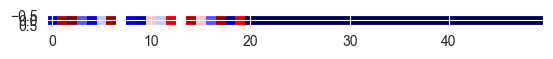

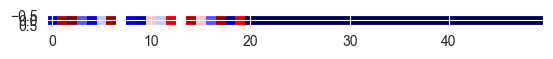

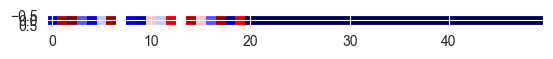

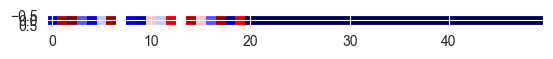

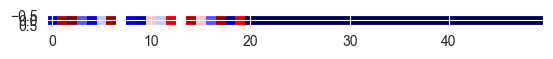

In [28]:
from matplotlib import pyplot as plt
for i in range(5):
    plt.imshow(main_ds_inf_b[i], interpolation='nearest', cmap='seismic') # TODO CUSTOM COLORS FOR AA
    plt.show()

In [45]:
main_ds_inf_b[0].shape

(1, 50, 1)

In [136]:
def batch_generator(X, Y, batch_size = 64):
    complete_batches = []
    x1, x2 = X
    indices = np.arange(len(x1))
    x1_array = []
    x2_array = []
    y_array = []
    for index, i in enumerate(x1):

        x1_array.append(i)
        x2_array.append(x2[index])
        y_array.append(Y[index])
        if len(x1_array)==batch_size:
            yield [x1_array, x2_array], y_array
            complete_batches.append([x1_array, x2_array], y_array)
            x1_array = []
            x2_array = []
            y_array = []
    return complete_batches


In [158]:
train_generator = batch_generator([main_ds_inf_a, main_ds_inf_b], main_ds_labels_inf, batch_size = 32)
for batch in train_generator:
    intensities = tf.convert_to_tensor(batch[0][0], dtype=tf.int32)
    sequences = tf.convert_to_tensor(batch[0][1], dtype=tf.int32)
    labels = np.array(batch[1], dtype=np.float32)
    print(intensities)
    print(sequences)

    yhat = inf_model.predict([intensities, sequences], labels, epochs=10)
    #eval_prec.update_state(labels , yhat)
    #eval_rec.update_state(labels, yhat)
    #eval_acc.update_state(labels, yhat)

tf.Tensor(
[[ 7552496]
 [ 7674974]
 [ 3298128]
 [ 1224600]
 [ 3298128]
 [ 7674974]
 [  738984]
 [ 7552496]
 [  717420]
 [ 1224600]
 [  753918]
 [  848189]
 [  921869]
 [16061060]
 [ 1667595]
 [  717122]
 [ 7668974]
 [  640085]
 [ 5893717]
 [ 1769198]
 [16061060]
 [ 1202825]
 [ 1125402]
 [16061060]
 [ 4053095]
 [ 3166896]
 [ 2297972]
 [16061060]
 [ 1761347]
 [  379347]
 [ 3478414]
 [ 2746510]], shape=(32, 1), dtype=int32)
tf.Tensor(
[[[[ 300]
   [1600]
   [1800]
   ...
   [   0]
   [   0]
   [   0]]]


 [[[ 300]
   [1600]
   [1800]
   ...
   [   0]
   [   0]
   [   0]]]


 [[[ 300]
   [1600]
   [1800]
   ...
   [   0]
   [   0]
   [   0]]]


 ...


 [[[ 300]
   [1000]
   [1800]
   ...
   [   0]
   [   0]
   [   0]]]


 [[[ 300]
   [ 800]
   [1000]
   ...
   [   0]
   [   0]
   [   0]]]


 [[[ 300]
   [ 800]
   [1000]
   ...
   [   0]
   [   0]
   [   0]]]], shape=(32, 1, 50, 1), dtype=int32)
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\micro\OneDrive\Dokumente\GitHub\BachelorThesis\venv\Lib\site-packages\IPython\core\interactiveshell.py", line 3460, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\micro\AppData\Local\Temp\ipykernel_28136\1210882676.py", line 9, in <module>
    yhat = inf_model.predict([intensities, sequences], labels, epochs=10)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\micro\OneDrive\Dokumente\GitHub\BachelorThesis\venv\Lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\micro\OneDrive\Dokumente\GitHub\BachelorThesis\venv\Lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
    filtered_tb = _process_traceback_frames(e.__traceback__)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: Model.predict() got an unexpected keyword argumen

In [756]:
print(f'Precision: {eval_prec.result().numpy()}, Recall: {eval_rec.result().numpy()}, Accuracy: {eval_acc.result().numpy()}')

In [757]:
from tensorflow.keras import preprocessing
from tensorflow.keras import backend as K
from tensorflow.keras import models
from PIL import Image
import matplotlib.pyplot as plt
import textwrap
from matplotlib import cm
import tensorflow as tf
import numpy as np


for layerpos in range(len(model.layers)-1):
    try:
        image_size = general_image_size

        # Load pre-trained Keras model and the image to classify TODO VERIFY
        img_tensor = labeled
        img_tensor = np.expand_dims(img_tensor, axis=0)

        select_layer = model.layers[layerpos].name #was -4
        print(select_layer)
        conv_layer = model.get_layer(select_layer)
        heatmap_model = models.Model([model.inputs], [conv_layer.output, model.output])

        heatmaps_generated = set()
        heatmap_list = []
        for pndex, value in enumerate(predictions[0]):
            with tf.GradientTape() as gtape:
                conv_output, predictions = heatmap_model(img_tensor)
                loss = predictions[0][pndex]
                grads = gtape.gradient(loss, conv_output)
                pooled_grads = K.mean(grads, axis=(0, 1, 2))

            heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_output), axis=-1)
            heatmap = np.maximum(heatmap, 0)
            max_heat = np.max(heatmap)
            if max_heat == 0:
                max_heat = 1e-10
            heatmap /= max_heat
            heatmaps_generated.add(heatmap.shape)
            heatmap_list.append(heatmap)
        print(heatmaps_generated)

        images_hm = []
        titles_hm = []
        predictions_hm = []

        for i in range(num_classes):
            # predictions
            prediction_value = (predictions[0][i])
            predictions_hm.append(prediction_value)

            # titles
            title = class_names[i]
            titles_hm.append(title)

            # images
            hm=np.squeeze(heatmap_list[i])

            current_img = (asarray(hm))
            sm = cm.ScalarMappable(cmap='seismic')
            sm.set_clim(current_img.min(), current_img.max())
            current_img = sm.to_rgba(current_img)
            current_img = current_img*255
            current_img = current_img.astype(np.uint8)
            current_img = cv2.cvtColor(current_img, cv2.COLOR_BGRA2BGR )
            images_hm.append(current_img)

        # plot them
        #print(len(images_hm))
        plot_image_grid(images_hm, titles_hm, predictions_hm, layername=select_layer)
    except:
        print("error", layerpos, end=" ")


# IGNORE FROM HERE

## Check in with Franzi's group for reporting

### Multilable Model
#### WIP in precursor_charge_predictor

## Model Testing
### check if models only predict charge 2 or also other charges. Due to 'overrepresentation' the best bet for the model could be to only output charge state 2

## Hyperparameter Tuning

# Inference

In [285]:
batches_parquet[file_list[1]]["precursor_charge"].value_counts()

2    1401912
3     787278
4     220159
Name: precursor_charge, dtype: int64

In [286]:
last_model = keras.models.load_model('precursor_charge_prediction_model_cce_alpha/cce_wo7_allSequences.h5')

In [287]:
batches_parquet.keys()

dict_keys(['data/Thermo_SRM_Pool_meta_data.parquet', 'data/TUM_aspn_meta_data.parquet'])

In [288]:
# Make validation data
inference_df = batches_parquet[file_list[1]][["precursor_charge", "modified_sequence_vector", "precursor_intensity"]].copy()

In [289]:
inference_df.head(4)

,precursor_charge,modified_sequence_vector,precursor_intensity
0,2,"[300, 1600, 1800, 600, 400, 800, 1700, 900, 40...",7552496.0
1,2,"[300, 1600, 1800, 600, 400, 800, 1700, 900, 40...",7674974.0
2,2,"[300, 1600, 1800, 600, 400, 800, 1700, 900, 40...",3298128.0
3,2,"[300, 1600, 1800, 600, 400, 800, 1700, 900, 40...",1224600.0


In [290]:
[len(i) for i in inference_df["modified_sequence_vector"] if len(i) != 50]

[]

In [291]:
inference_df = inference_df[inference_df['modified_sequence_vector'].apply(lambda x: len(x) <= 50)]

In [292]:
[len(i) for i in inference_df["modified_sequence_vector"] if len(i) != 50]

[]

In [293]:
[i for i in inference_df["precursor_charge"] if i not in [2,3,4]]

[]

In [294]:
[i for i in inference_df["precursor_intensity"] if i > 1000000000000]

[]

In [295]:
inference_df

,precursor_charge,modified_sequence_vector,precursor_intensity
0,2,"[300, 1600, 1800, 600, 400, 800, 1700, 900, 40...",7552496.0
1,2,"[300, 1600, 1800, 600, 400, 800, 1700, 900, 40...",7674974.0
2,2,"[300, 1600, 1800, 600, 400, 800, 1700, 900, 40...",3298128.0
3,2,"[300, 1600, 1800, 600, 400, 800, 1700, 900, 40...",1224600.0
4,2,"[300, 1600, 1800, 600, 400, 800, 1700, 900, 40...",3298128.0
...,...,...,...
2586142,3,"[300, 1800, 1000, 1600, 1200, 204, 400, 500, 1...",10454540.0
2586148,3,"[300, 800, 1500, 800, 900, 400, 400, 400, 1300...",5171662.0
2586154,4,"[300, 400, 1400, 1800, 100, 1000, 900, 900, 90...",37526080.0
2586155,3,"[300, 1300, 300, 1300, 1400, 1300, 1500, 2000,...",8926203.0


In [296]:
inference_df[list(range(0, 50))] = pd.DataFrame(inference_df["modified_sequence_vector"].tolist(), index= inference_df.index)

KeyboardInterrupt: 

In [ ]:
inference_df.drop("modified_sequence_vector", axis=1, inplace=True)

In [ ]:
inference_df.head(4)

In [ ]:
inference_ds = tf.convert_to_tensor(inference_df)

In [ ]:
inference_target = inference_ds[:, 0]
inference_features = inference_ds[:, 1:]

In [ ]:
inference_target_labels =  np.array([one_hot_precursor(i, charges=charge_ranges) for i in inference_target])

In [ ]:
results = model_cce.evaluate(inference_features, inference_target_labels, batch_size=256)
print("test loss, test acc:", results)

## Evaluate the models
- confusion matrix
- accuracy
- loss

Confusion Matrix

In [ ]:
import sklearn
matrix = sklearn.metrics.confusion_matrix(train_ds_labels.argmax(axis=1), inference_target_labels.argmax(axis=1))

In [ ]:
#!pip install scikit-learn
#!pip install numpy --upgrade
#!pip install pandas --upgrade
#!pip install matplotlib --upgrade
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import pandas as pd
#do_predictions = model.predict(test_ds)

y_pred = []
y_true = []

# iterate over the dataset
for index, i in enumerate(inference_ds):   # use dataset.unbatch() with repeat
   print(inference_target_labels[index])
   print(inference_features[index])
   # append true labels
   y_true.append(inference_target_labels[index])
   # compute predictions
   preds = model_cce.predict(inference_features[index])
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = -1))
# convert the true and predicted labels into tensors
true_labels = tf.cast(tf.concat([item for item in y_true], axis = 0), tf.float32)
predicted_labels = tf.cast(tf.concat([item for item in y_pred], axis = 0), tf.float32)


cm = confusion_matrix(true_labels, predicted_labels)
#print(cm)
report = classification_report(true_labels,predicted_labels, target_names=class_names)

report_dict = classification_report(true_labels, predicted_labels, output_dict=True)
#print(report_dict)
print(report)

#pd.DataFrame(report_dict).transpose()


Accuracy/ Sens/ Spec

In [ ]:
import keras.backend as K
def matthews_correlation(y_true, y_pred):
    #print(y_pred.shape, y_true.shape)
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(K.cast(y_pos * y_pred_pos, 'float32'))
    tn = K.sum(K.cast(y_neg * y_pred_neg, 'float32'))
    fp = K.sum(K.cast(y_neg * y_pred_pos, 'float32'))
    fn = K.sum(K.cast(y_pos * y_pred_neg, 'float32'))

    print("OVERALL:")
    print(" Accuracy ", ((tp + tn) / (tp + tn + fp + fn)).numpy())
    print(" Sensitivity ", (tp / (tp + fn)).numpy())
    print(" Specificity ", (tn / (tn + fp)).numpy())

    numerator = (tp * tn - fp * fn)
    #print(tp.numpy(), fp.numpy())
    test = (((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)))
    #print(test)
    denominator = K.sqrt(K.cast(test, 'float32'))

    return numerator / (denominator + K.epsilon())


#print(true_labels, predicted_labels)
print(" matthews_correlation(rounded): ", (matthews_correlation(true_labels, predicted_labels).numpy()))

MCC

In [ ]:
from sklearn.metrics import matthews_corrcoef

print("matthews_correlation:", matthews_corrcoef(true_labels, predicted_labels))

Direct eval:

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

eval_prec = Precision()
eval_rec = Recall()
eval_acc = BinaryAccuracy()

In [ ]:
for batch in test_ds.as_numpy_iterator():
    X, y = batch
    y = tf.keras.utils.to_categorical(y, num_classes=13, dtype='int')
    yhat = model.predict(X)
    eval_prec.update_state(y, yhat)
    eval_rec.update_state(y, yhat)
    eval_acc.update_state(y, yhat)

In [ ]:
print(f'Precision: {eval_prec.result().numpy()}, Recall: {eval_rec.result().numpy()}, Accuracy: {eval_acc.result().numpy()}')